In [7]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import tqdm
import pickle

import robustness_model

In [2]:
train_data = datasets.MNIST(root = './datasets/',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root = './datasets/',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

number of training data :  60000
number of test data :  10000


In [3]:
X_train = train_data.data
y_train = train_data.targets
X_test = test_data.data
y_test = test_data.targets

In [4]:
X_train = X_train[(y_train == 0) | (y_train == 1)].reshape(-1, 28*28) / 255
y_train = y_train[(y_train == 0) | (y_train == 1)]
X_test = X_test[(y_test == 0) | (y_test == 1)].reshape(-1, 28*28) / 255
y_test = y_test[(y_test == 0) | (y_test == 1)]

In [5]:
original_dim = 28*28
dim = 10000

In [6]:
def overall_robustness_method3(model: robustness_model.ClassificationModel, X):
    
    ep3s = []

    max_X, L3, method3_history = model.get_conservative_lipschitz_constant_gd(epochs=2000, show_pbar=False)

    for x in X:
        ep3 = model.get_eps(x, L3)
        ep3s.append(ep3)
    
    return torch.tensor(ep3s).mean()

In [8]:
def train(sample_size=10, lr=0.001, epochs=50):

    theta = torch.nn.parameter.Parameter(torch.randn(1)[0].abs()) # theta = (0, sigma) = (sigma)
    optimizer = torch.optim.Adam([theta], lr=lr)

    loss_history = []
    theta_history = []
    epsilon_history = []

    with tqdm.tqdm(total=epochs) as pbar:

        for i in range(epochs):

            optimizer.zero_grad()

            dists = torch.distributions.Normal(0.0, theta)
            samples = dists.sample(sample_shape=torch.Size((sample_size, dim, original_dim)))
            
            epsilons = []
            for sample in samples:
                encoder = robustness_model.FHRREncoder(original_dim, dim, M=sample)
                model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
                model.bundling(X_test, y_test) # X_train, y_train

                epsilon = overall_robustness_method3(model, X_test) # X_train
                epsilons.append(epsilon)
            epsilons = torch.tensor(epsilons)

            # REINFORCE
            loss = sum(epsilon.item() * dists.log_prob(sample).mean() for epsilon, sample in zip(epsilons, samples)) / sample_size
            loss = -loss# .mean()
            loss.backward()

            optimizer.step()

            loss_history.append(loss.item())
            theta_history.append(theta.item())
            epsilon_history.append(epsilons.mean().item())

            pbar.update(1)
            pbar.set_postfix({
                'Loss': loss.item(),
                'Theta': theta.item(),
                'Epsilon': epsilons.mean().item(),
            })

    return loss_history, theta_history, epsilon_history


trial 0


100%|██████████| 50/50 [3:25:00<00:00, 246.01s/it, Loss=0.591, Theta=1.57, Epsilon=0.316]    


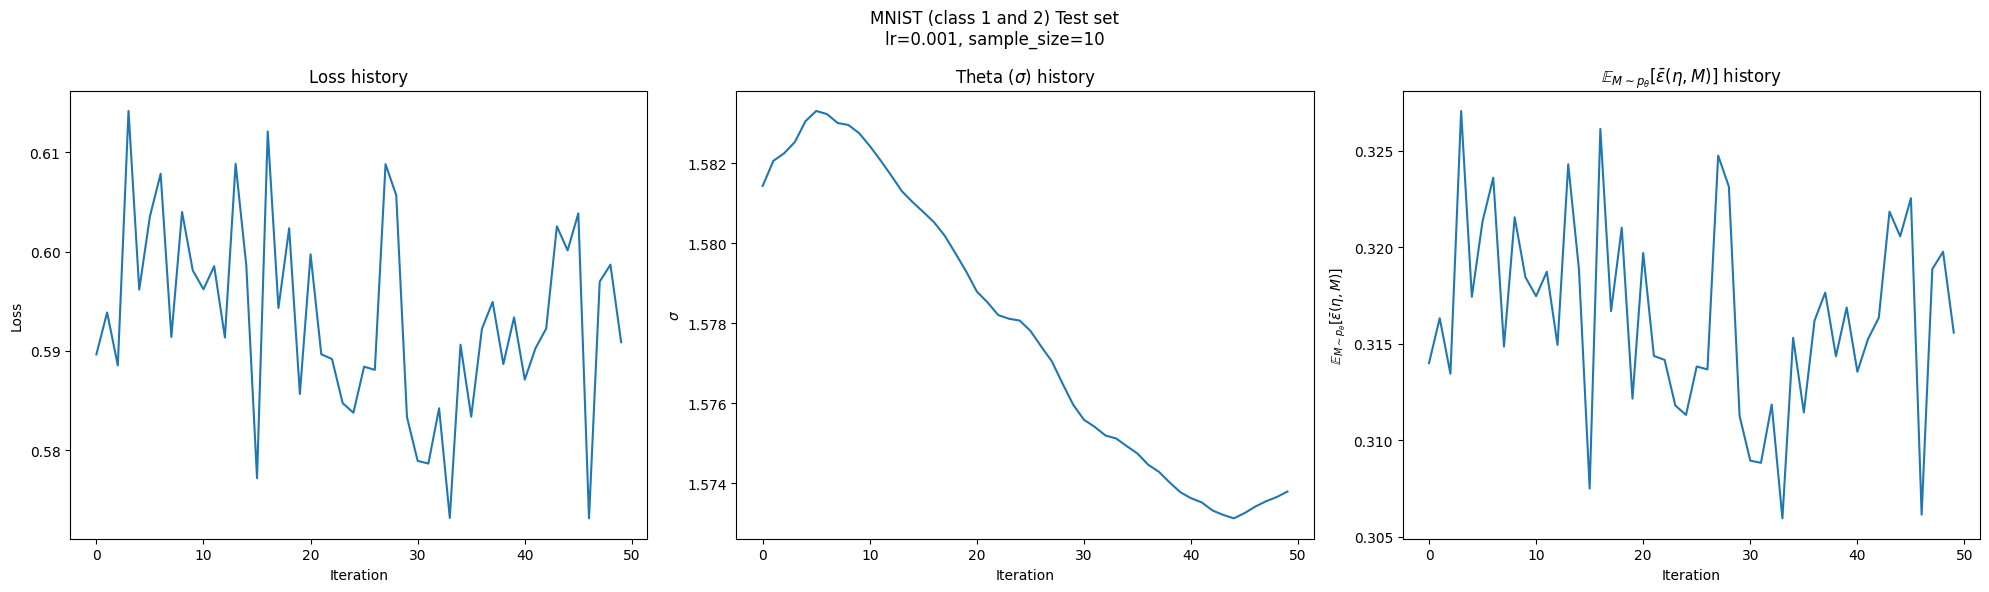

trial 1


100%|██████████| 50/50 [1:26:13<00:00, 103.46s/it, Loss=0.138, Theta=0.296, Epsilon=0.69] 


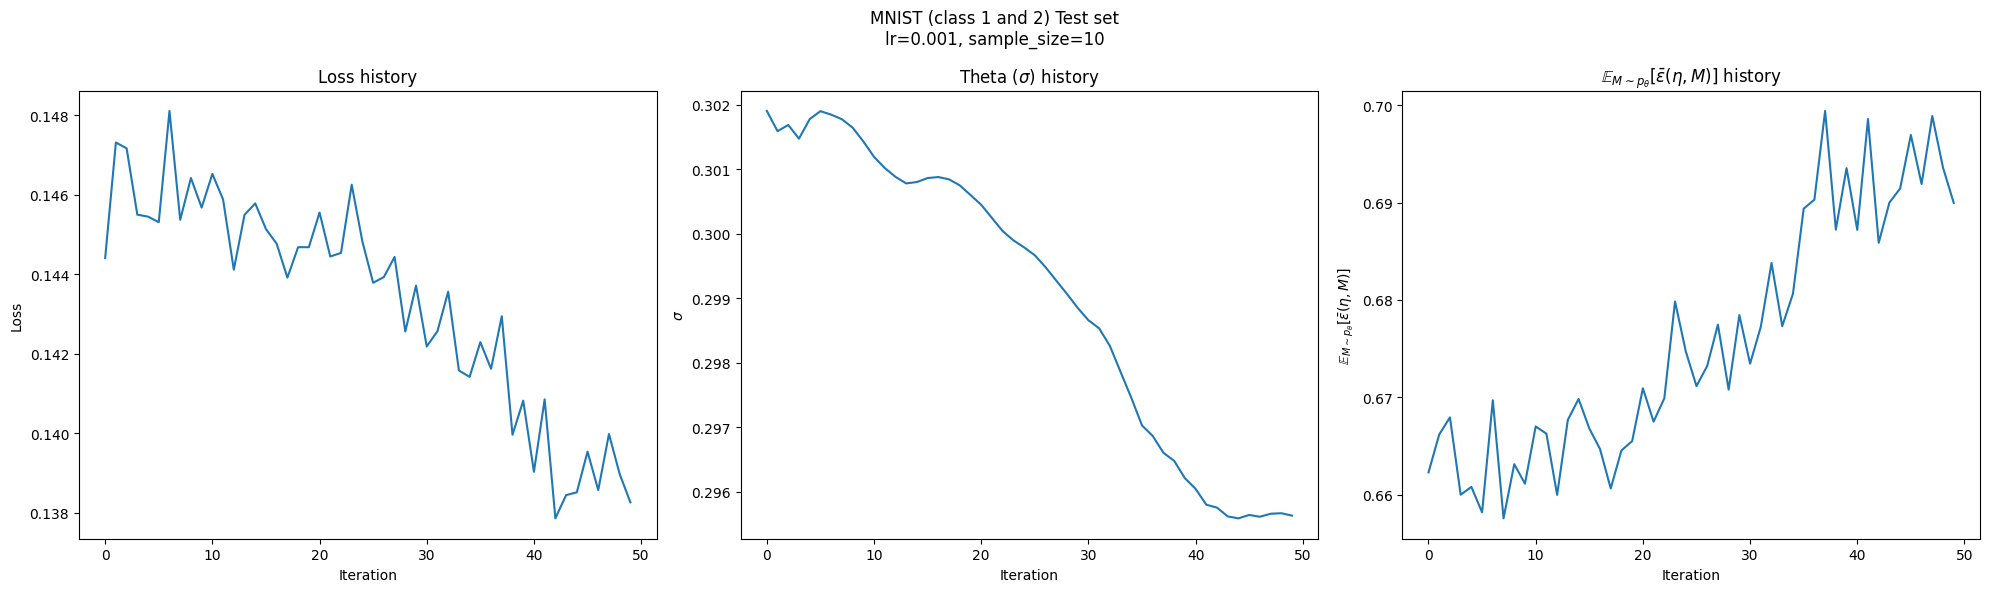

trial 2


100%|██████████| 50/50 [1:26:11<00:00, 103.43s/it, Loss=-30.8, Theta=0.0306, Epsilon=14.8]


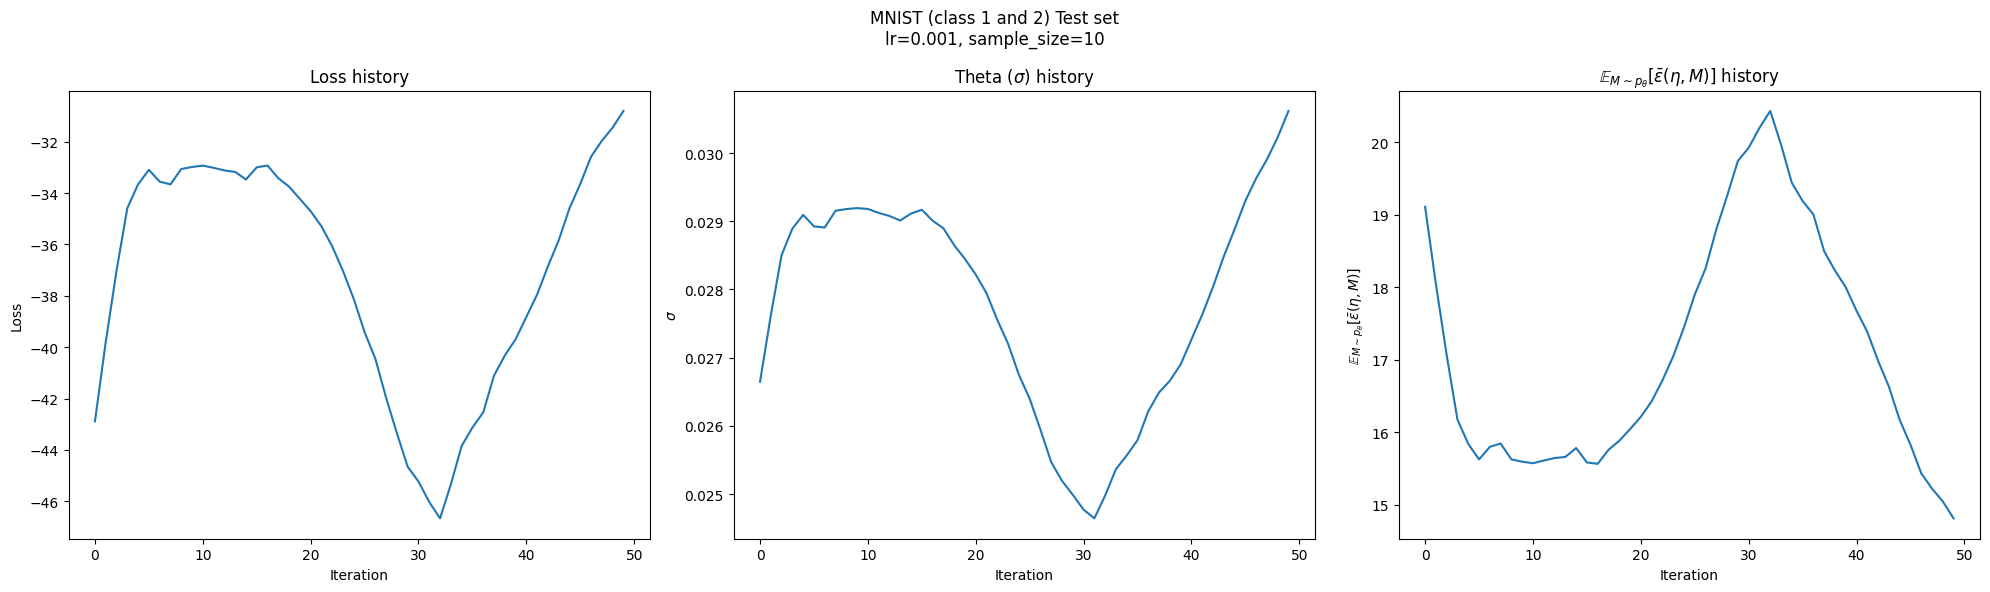

trial 3


100%|██████████| 50/50 [1:39:54<00:00, 119.90s/it, Loss=0.666, Theta=1.73, Epsilon=0.339]


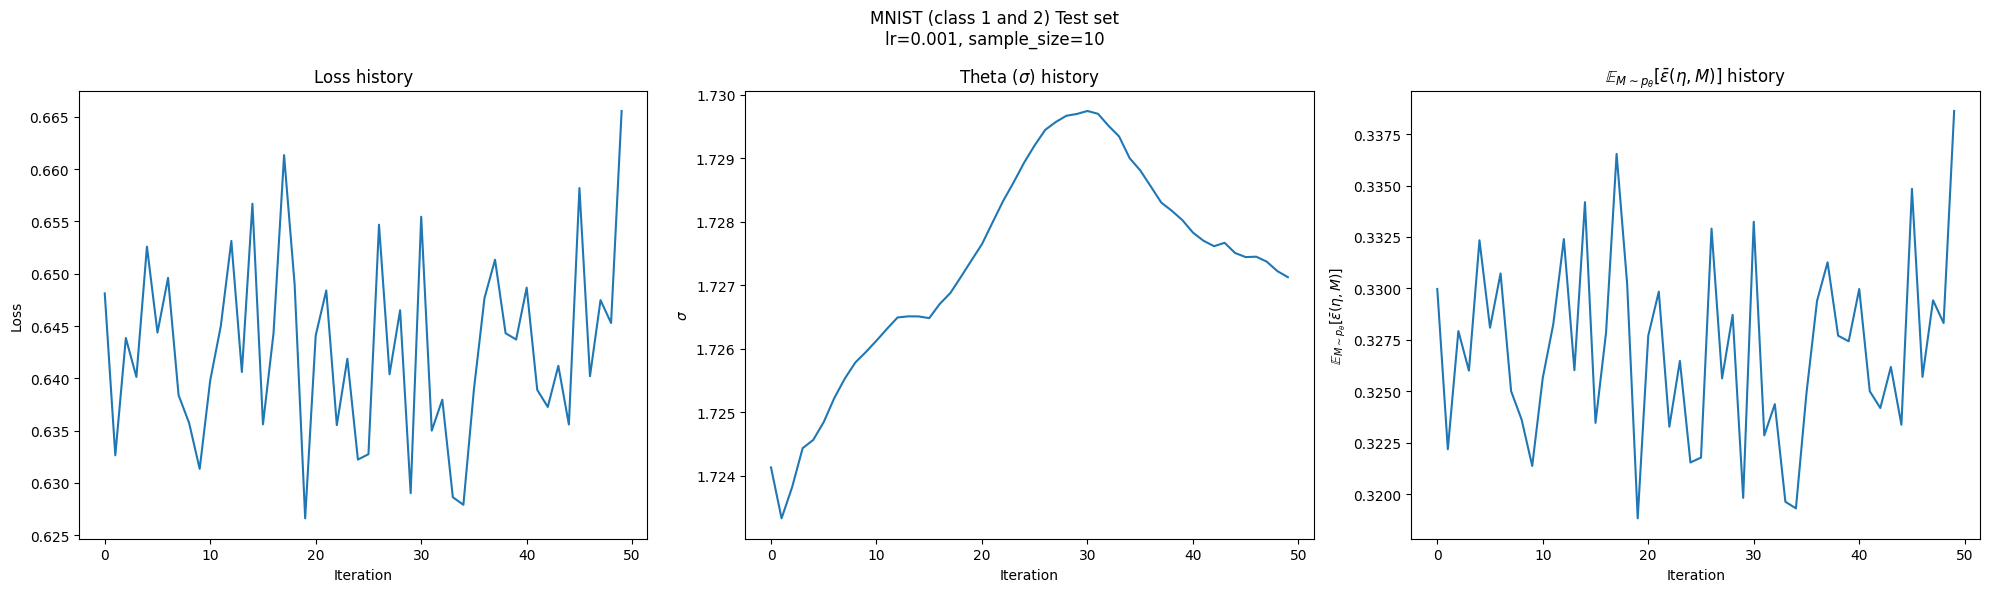

trial 4


100%|██████████| 50/50 [1:43:27<00:00, 124.15s/it, Loss=0.103, Theta=0.576, Epsilon=0.118]


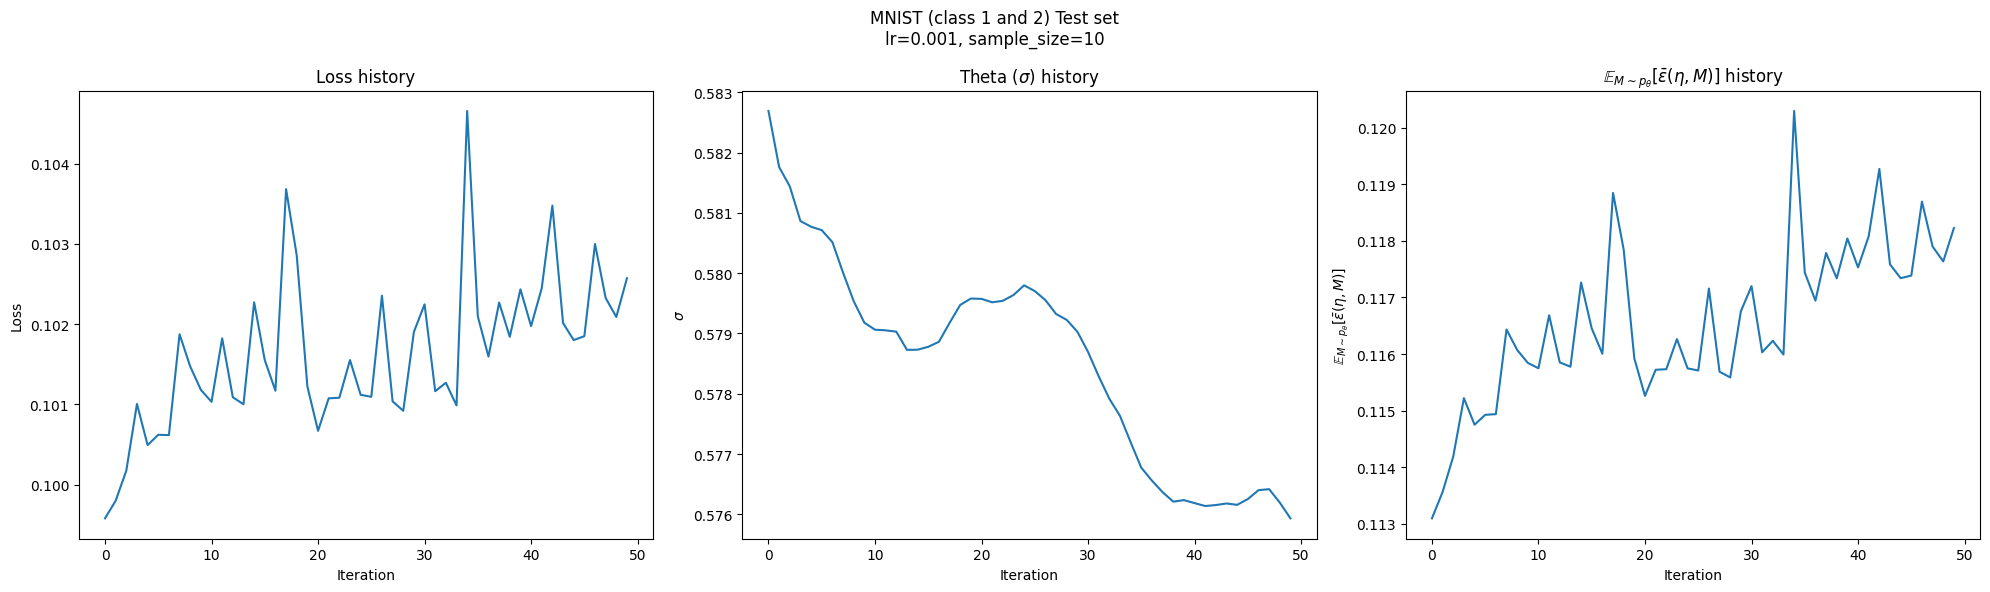

trial 5


100%|██████████| 50/50 [1:43:25<00:00, 124.12s/it, Loss=0.0551, Theta=0.777, Epsilon=0.0472]


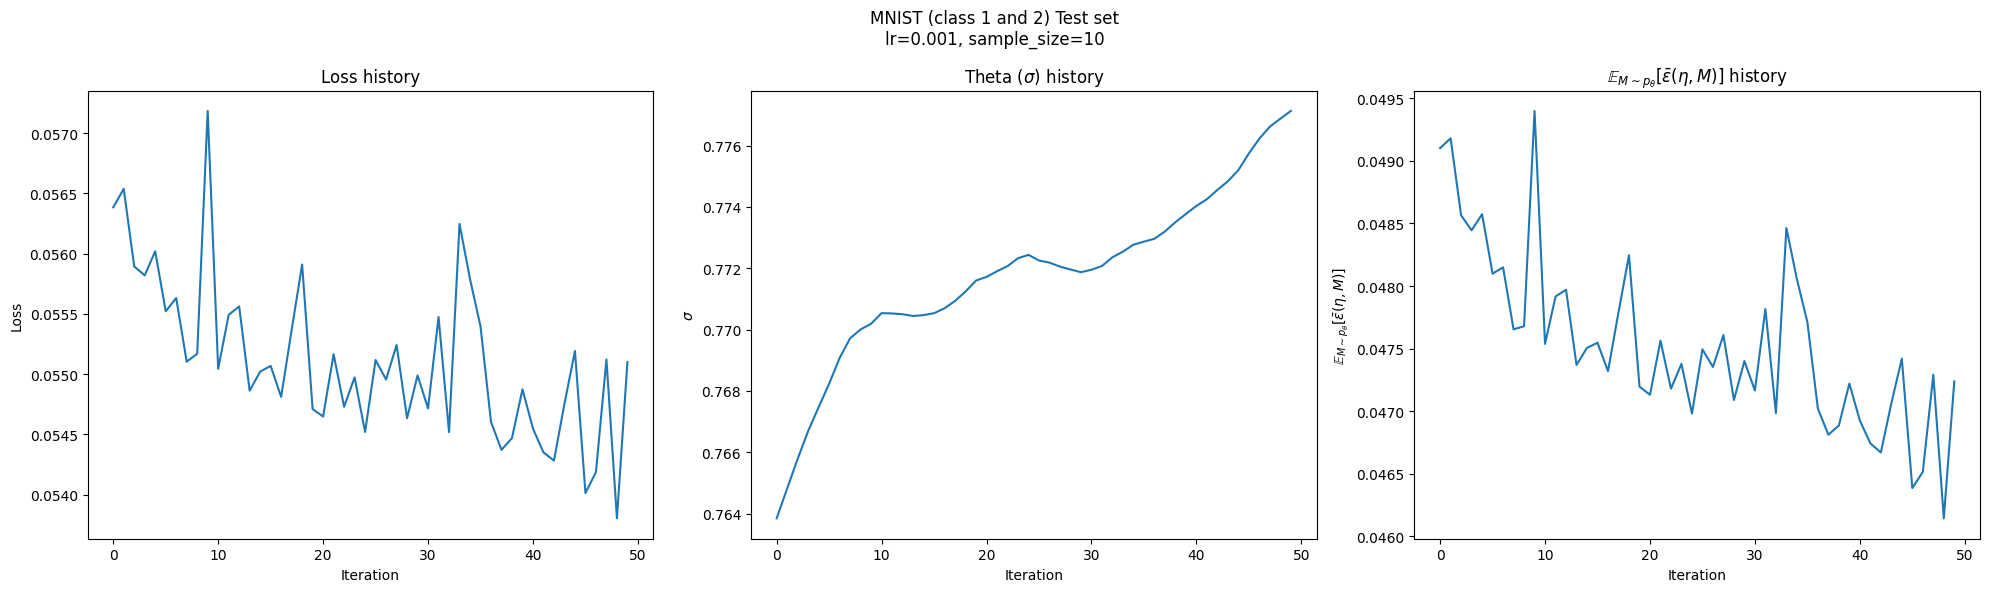

trial 6


100%|██████████| 50/50 [1:43:24<00:00, 124.09s/it, Loss=0.0729, Theta=0.677, Epsilon=0.0708]


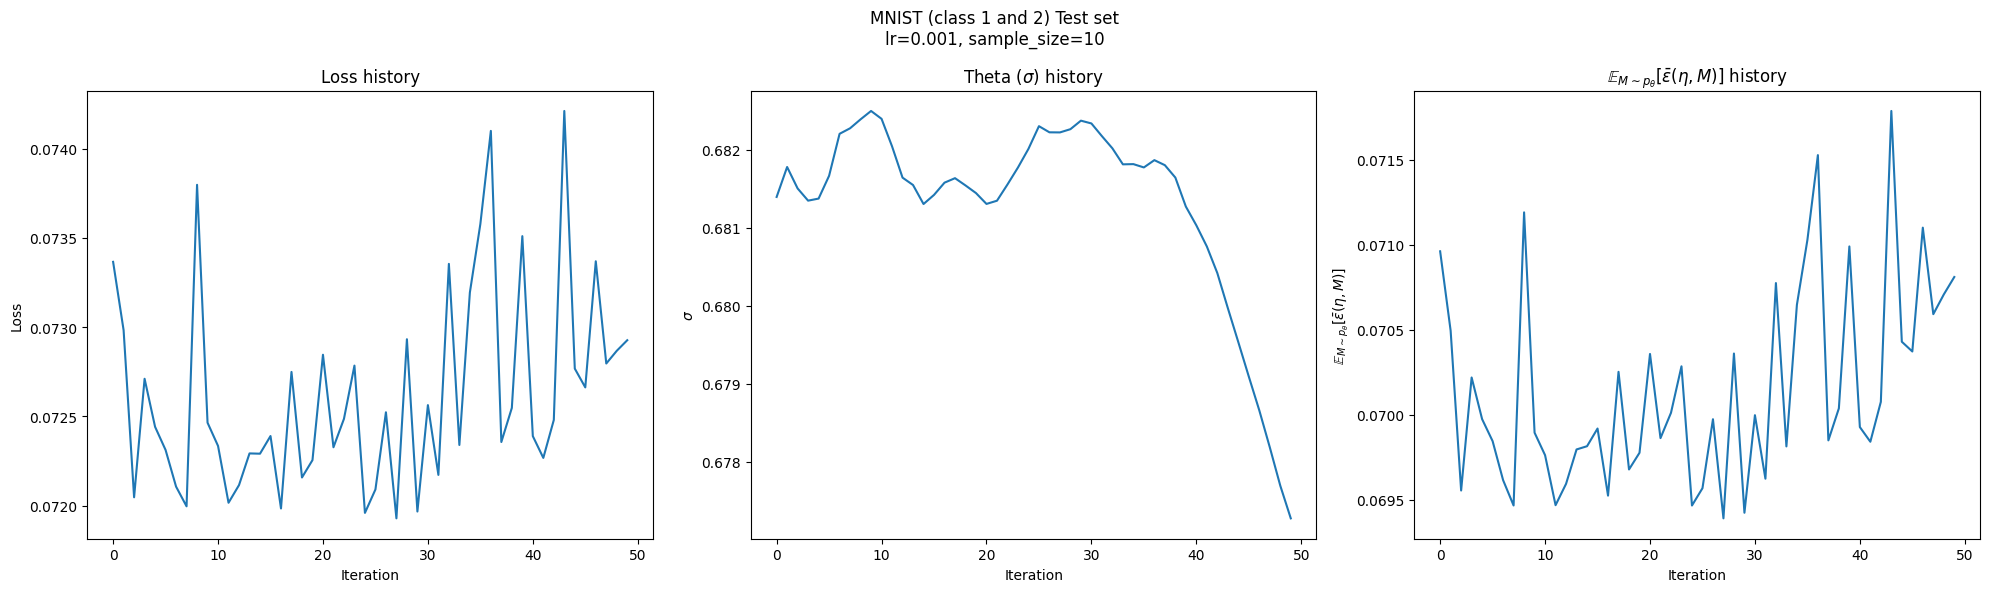

trial 7


100%|██████████| 50/50 [1:43:31<00:00, 124.23s/it, Loss=-6.45, Theta=0.0624, Epsilon=4.75]


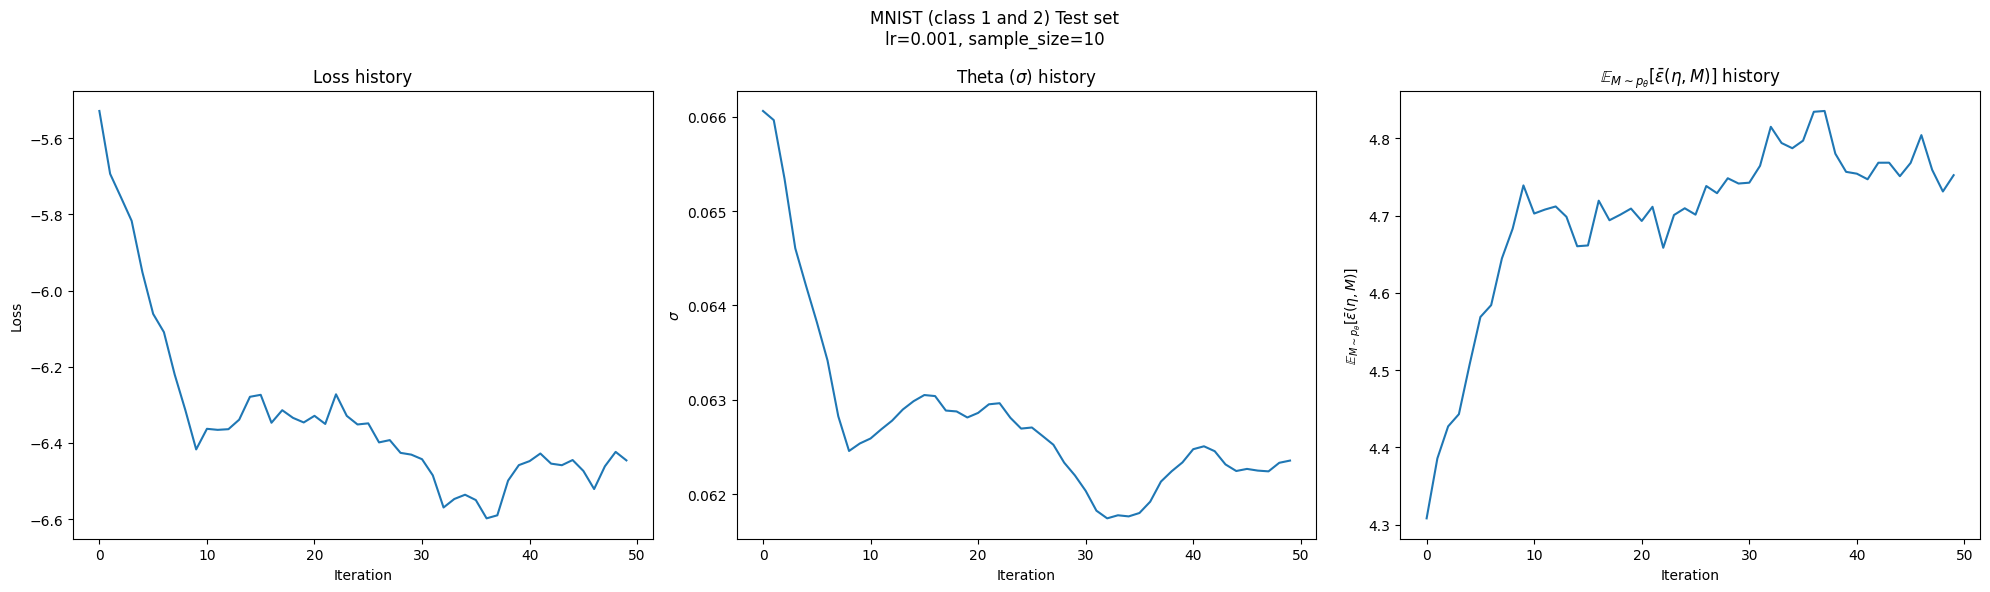

trial 8


100%|██████████| 50/50 [1:44:37<00:00, 125.55s/it, Loss=-.554, Theta=0.174, Epsilon=1.7] 


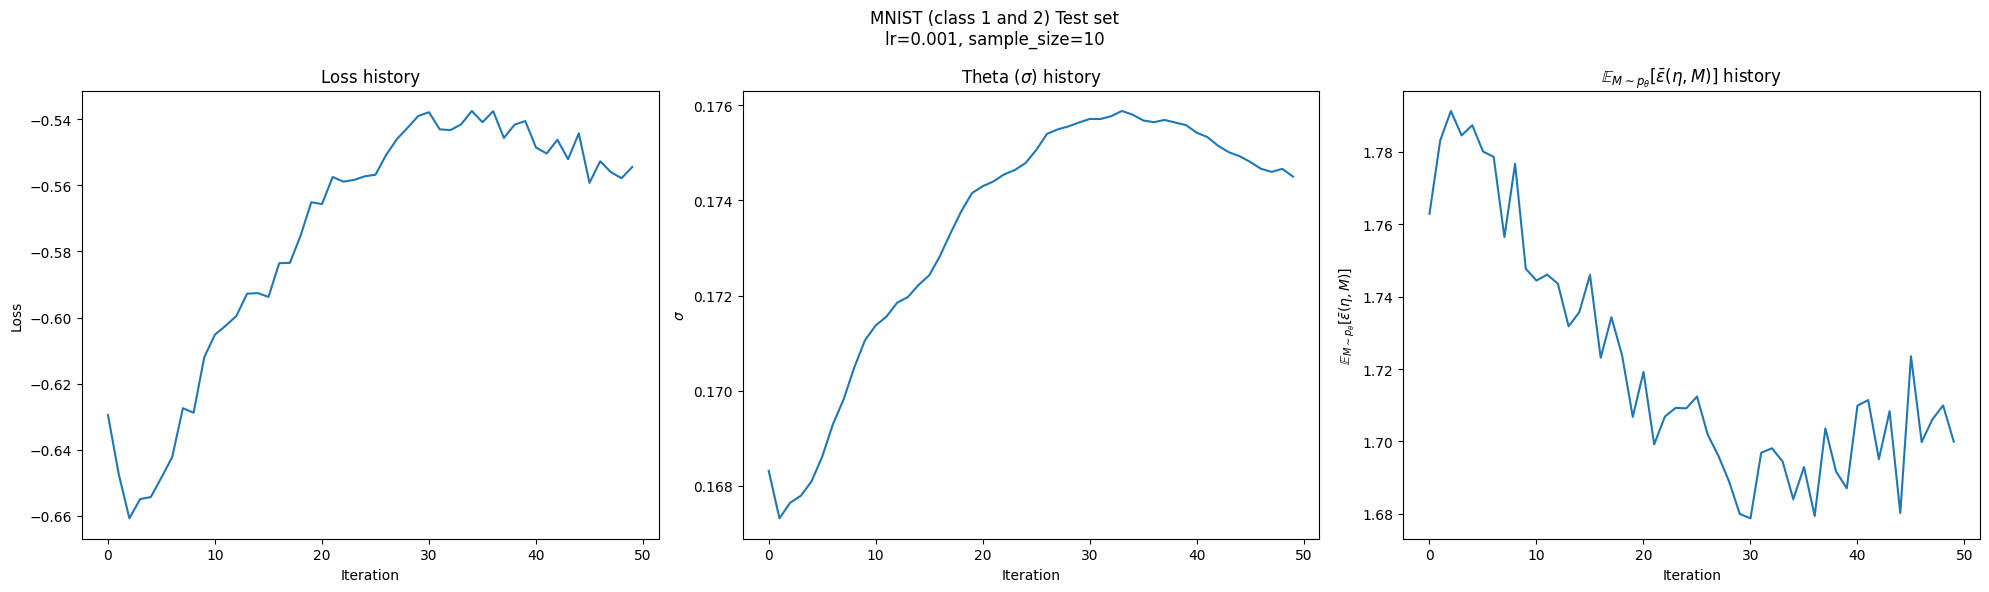

trial 9


100%|██████████| 50/50 [7:35:27<00:00, 546.55s/it, Loss=0.0508, Theta=1.02, Epsilon=0.0354]    


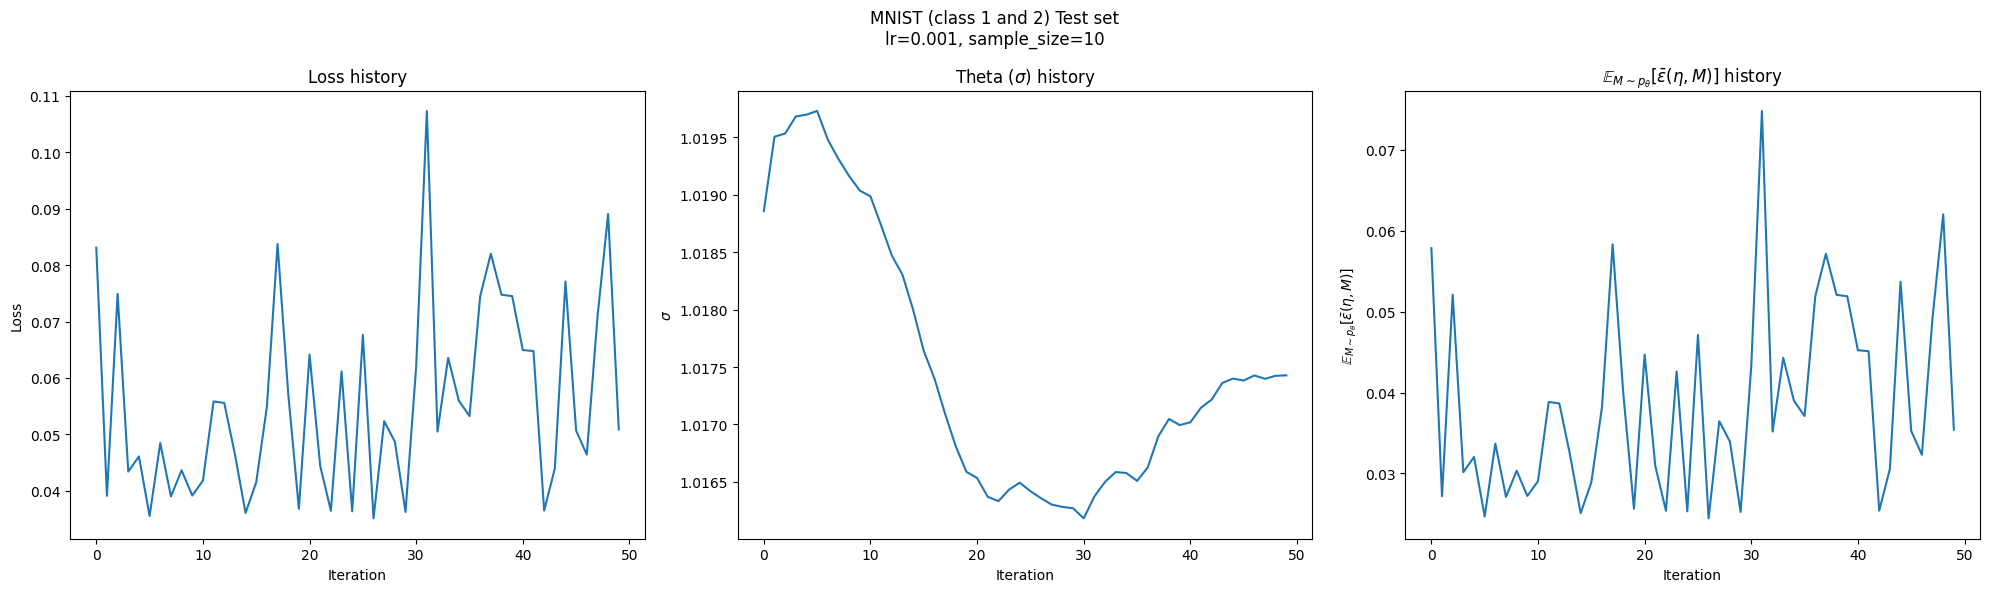

In [9]:
sample_size = 10
lr = 0.001
epochs = 50

for trial in range(10):
    print('trial', trial)

    loss_history, theta_history, epsilon_history = train(sample_size=sample_size, lr=lr, epochs=epochs)

    fig, axes = plt.subplots(1, 3, dpi=100, figsize=(20, 6))
    axes[0].set_title('Loss history')
    axes[0].plot(loss_history)
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Loss')
    axes[1].set_title('Theta ($\sigma$) history')
    axes[1].plot(theta_history)
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('$\sigma$')
    axes[2].set_title('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$ history')
    axes[2].plot(epsilon_history)
    axes[2].set_xlabel('Iteration')
    axes[2].set_ylabel('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$')
    fig.suptitle(f'MNIST (class 1 and 2) Test set\nlr={lr}, sample_size={sample_size}')
    fig.tight_layout()
    plt.show()